In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.colors import to_rgba

# Darken color utility
def darken(color, factor=0.6):
    r, g, b, a = to_rgba(color)
    return (r * factor, g * factor, b * factor, a)

# Unified Step Grouping Definitions
common_group1_steps = [
    "Aggregate BLS keys", "Aggregate BLS signatures", "Generate N PoOs",
    "Generate VC payload", "Sign with N issuer", "Create final VC",
    "JWTProof2020Create", "EIP712Proof2021Create", "Issue VCs"
]
common_group2_steps = [
    "Store VC", "Create VP",
    "JWTProof2020Present", "EIP712Proof2021Present",
    "Store VCs", "Create VP (N VCs)"
]
common_group3_steps = [
    "Verify VP", "BLS Signature Verification",
    "DID Documents Resolution", "Proofs of Ownership Verification",
    "JWTProof2020Verify", "EIP712Proof2021Verify",
    "Verify VP (N VCs)", "Verify VCs"
]

def classify_step(step):
    if step in common_group1_steps:
        return "Issuing"
    elif step in common_group2_steps:
        return "Store & Present"
    elif step in common_group3_steps:
        return "Verification"
    return "Other"

# Unified Color Palette - using a combination of tab20 and tab10 for more distinct colors
all_common_steps = sorted(list(set(common_group1_steps + common_group2_steps + common_group3_steps)))

# Get 20 colors from tab20 and remaining from tab10 to ensure distinctness for 23 steps
colors_tab20 = [matplotlib.colormaps['tab20'](i) for i in np.linspace(0, 1, 20)]
colors_tab10 = [matplotlib.colormaps['tab10'](i) for i in np.linspace(0, 1, 10)]

# Combine to get enough distinct colors (20 from tab20 + 3 from tab10)
common_colors = colors_tab20 + colors_tab10[:(len(all_common_steps) - len(colors_tab20))]

common_step_colors = {step: common_colors[i] for i, step in enumerate(all_common_steps)}

# Explicitly assign highly distinguishable colors to specific steps
common_step_colors['Create VP'] = 'darkred'
common_step_colors['Verify VP'] = 'darkgreen'
common_step_colors['Verify VP (N VCs)'] = 'purple'

In [ ]:
import pandas as pd

# Load the potential MultiSignature benchmark file for 16 claims
df_multi_16 = pd.read_csv('/content/benchmark_results_claims16_size64.csv')
# Load JwtProof2020 benchmark file for 16 claims
df_jwt_16 = pd.read_csv('/content/benchmark_standard_claims16_size64.csv')
# Load EIP712 benchmark file for 16 claims
df_eip_16 = pd.read_csv('/content/benchmark_standard_eip712_claims16_size64.csv')

# Load MultiSignature benchmark file for 128 claims
df_multi_128 = pd.read_csv('/content/benchmark_results_claims128_size64.csv')
# Load JwtProof2020 benchmark file for 128 claims
df_jwt_128 = pd.read_csv('/content/benchmark_standard_claims128_size64.csv')
# Load EIP712 benchmark file for 128 claims
df_eip_128 = pd.read_csv('/content/benchmark_standard_eip712_claims128_size64.csv')

print("Head of MultiIssVC/Benchmark Results data (df_multi_16):")
display(df_multi_16.head())

print("\nUnique StepNames in df_multi_16:")
display(df_multi_16['StepName'].unique())

Head of MultiIssVC/Benchmark Results data (df_multi_16):


,Issuers,StepName,avg_ms,std_ms
0,2,Aggregate BLS keys,1.217904,0.285298
1,2,Generate VC payload,0.088996,0.086676
2,2,Sign with N issuer,12.483392,2.170508
3,2,Generate N PoOs,8.321641,1.878222
4,2,Create final VC,3.721323,0.645970



Unique StepNames in df_multi_16:


array(['Aggregate BLS keys', 'Generate VC payload', 'Sign with N issuer',
       'Generate N PoOs', 'Create final VC', 'Store VC', 'Create VP',
       'Verify VP', 'BLS Signature Verification',
       'DID DocumentS Resolution', 'Proofs of Ownership Verification'],
      dtype=object)

## Small Size VC (16 Claims)

### MultiSignature (16 Claims) Plot

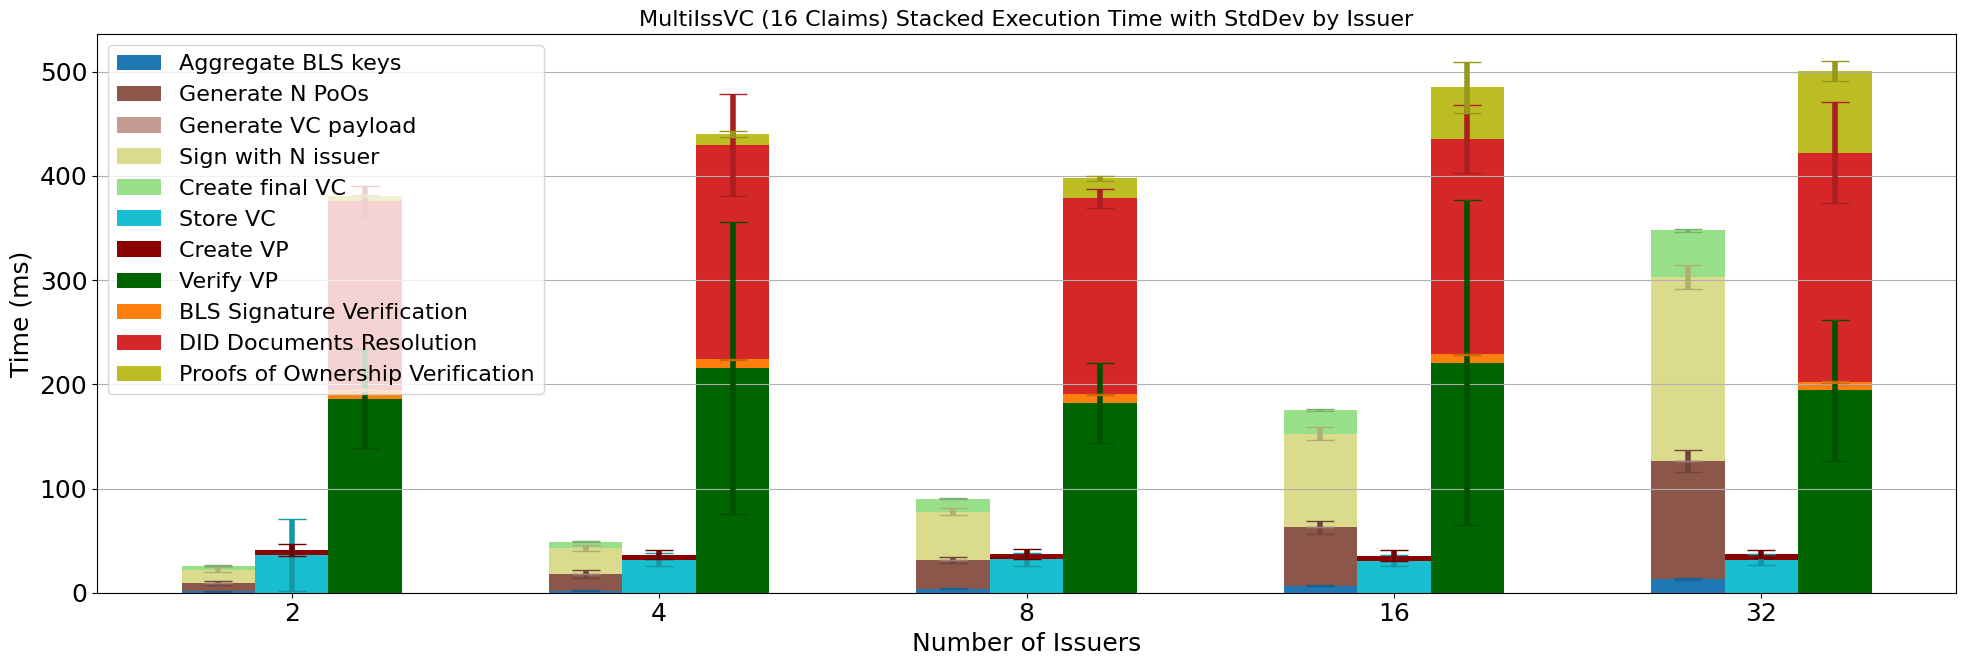

In [ ]:
# --- Process and Plot MultiSignature Data (df_multi_16) ---

# Fix typos
df_multi_16["StepName"] = df_multi_16["StepName"].replace({
    "DID DocumentS Resolution": "DID Documents Resolution"
})

# Classify steps
df_multi_16["OperationGroup"] = df_multi_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = df_multi_16.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df = df_multi_16.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

# Grouped step dictionary
grouped_steps_multi = {
    "Issuing": [step for step in common_group1_steps if step in avg_df.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df.columns]
}

# Plot
x_multi = np.arange(len(avg_df.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_multi.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df.columns:
            values = avg_df[step].values
            errors = std_df[step].values
            bars = ax.bar(x_multi + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_multi + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_multi)
ax.set_xticklabels(avg_df.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("MultiIssVC (16 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

### JwtProof2020 (16 Claims) Plot

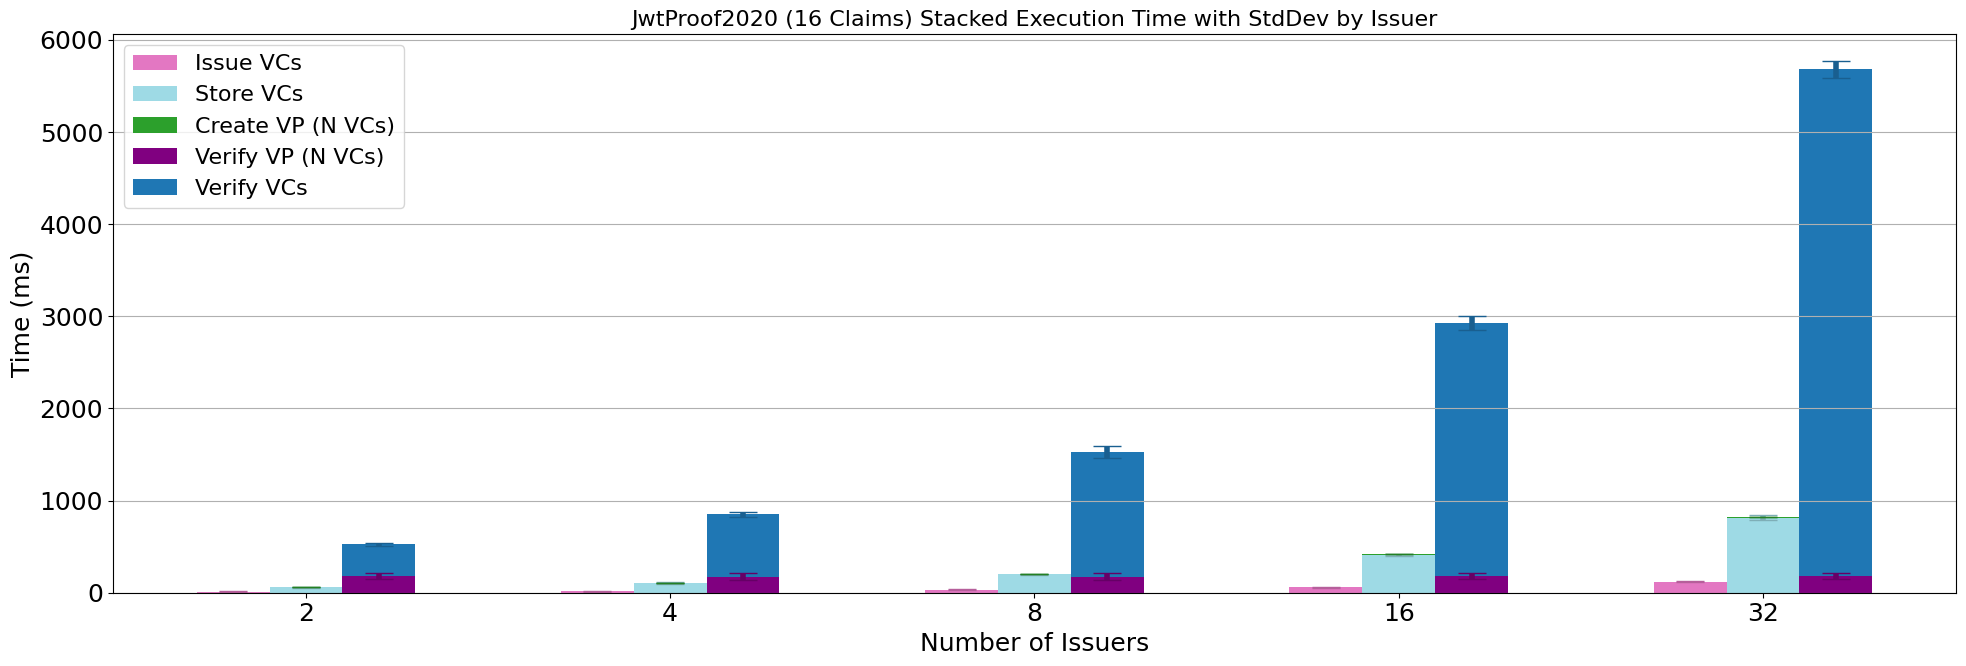

In [ ]:
# --- Process and Plot JwtProof2020 Data (df_jwt_16) ---

df_jwt_16["OperationGroup"] = df_jwt_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df_jwt_16 = df_jwt_16.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df_jwt_16 = df_jwt_16.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

grouped_steps_jwt = {
    "Issuing": [step for step in common_group1_steps if step in avg_df_jwt_16.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df_jwt_16.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df_jwt_16.columns]
}

# Plot
x_jwt = np.arange(len(avg_df_jwt_16.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_jwt.items()):
    bottom = np.zeros(len(avg_df_jwt_16))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df_jwt_16.columns:
            values = avg_df_jwt_16[step].values
            errors = std_df_jwt_16[step].values
            bars = ax.bar(x_jwt + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_jwt + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_jwt)
ax.set_xticklabels(avg_df_jwt_16.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("JwtProof2020 (16 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

### EIP712 (16 Claims) Plot

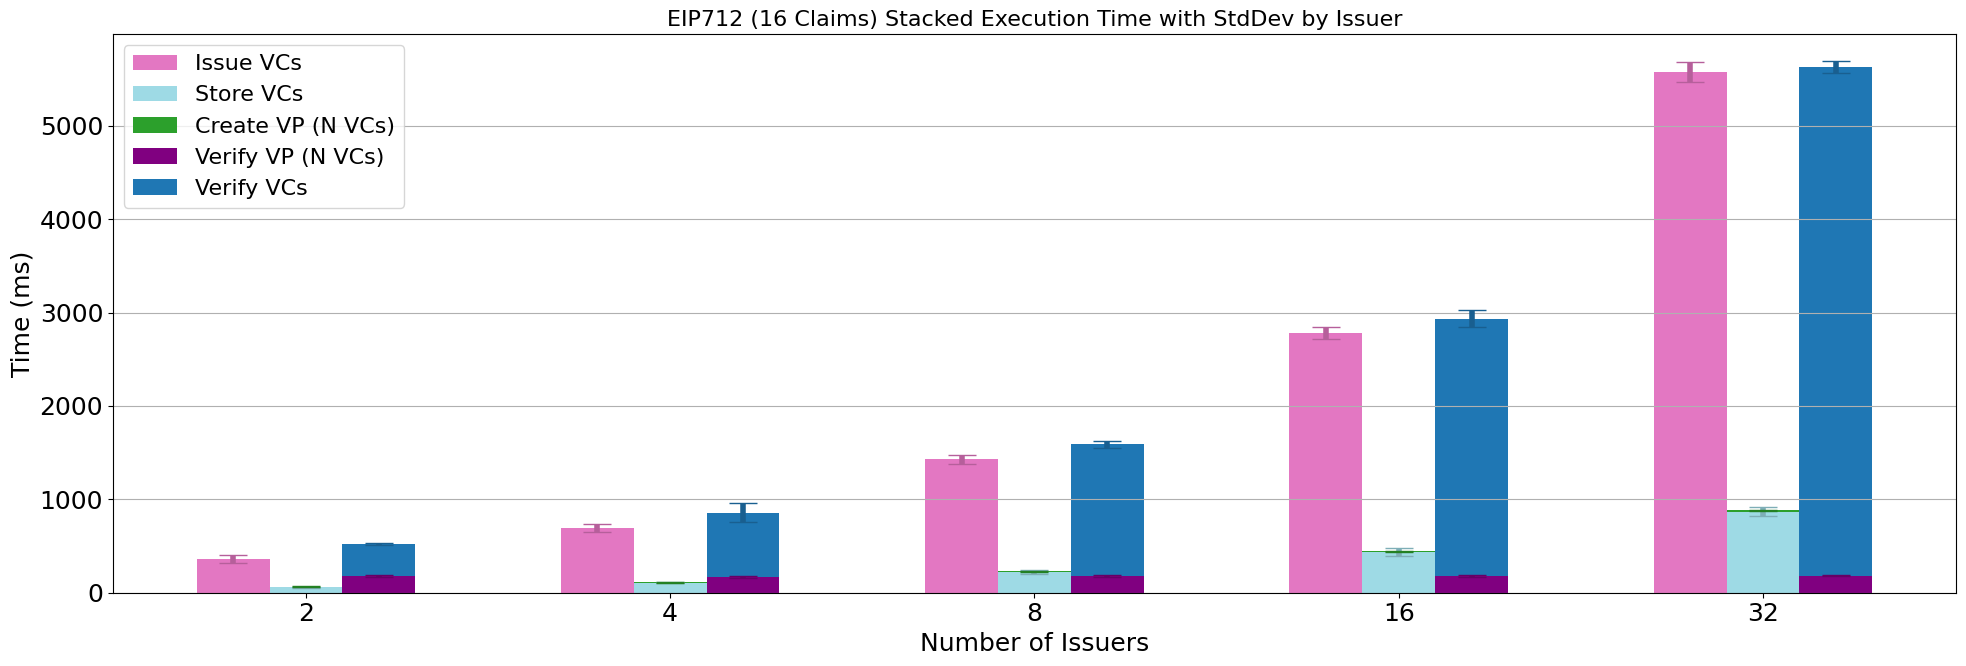

In [ ]:
# --- Process and Plot EIP712 Data (df_eip_16) ---

df_eip_16["OperationGroup"] = df_eip_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df_eip_16 = df_eip_16.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df_eip_16 = df_eip_16.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

grouped_steps_eip = {
    "Issuing": [step for step in common_group1_steps if step in avg_df_eip_16.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df_eip_16.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df_eip_16.columns]
}

# Plot
x_eip = np.arange(len(avg_df_eip_16.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_eip.items()):
    bottom = np.zeros(len(avg_df_eip_16))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df_eip_16.columns:
            values = avg_df_eip_16[step].values
            errors = std_df_eip_16[step].values
            bars = ax.bar(x_eip + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_eip + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_eip)
ax.set_xticklabels(avg_df_eip_16.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("EIP712 (16 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

In [ ]:
# Increase font sizes globally for research-article visibility
matplotlib.rcParams.update({
    'font.size': 18,               # base font size
    'axes.titlesize': 16,          # title font
    'axes.labelsize': 18,          # x/y label font
    'xtick.labelsize': 18,         # x-axis ticks
    'ytick.labelsize': 18,         # y-axis ticks
    'legend.fontsize': 16,         # legend text
    'legend.title_fontsize': 18,   # legend title (if used)
    'errorbar.capsize': 4
})

## Large Size VC (128 Claims)

### JwtProof2020 (128 Claims) Plot

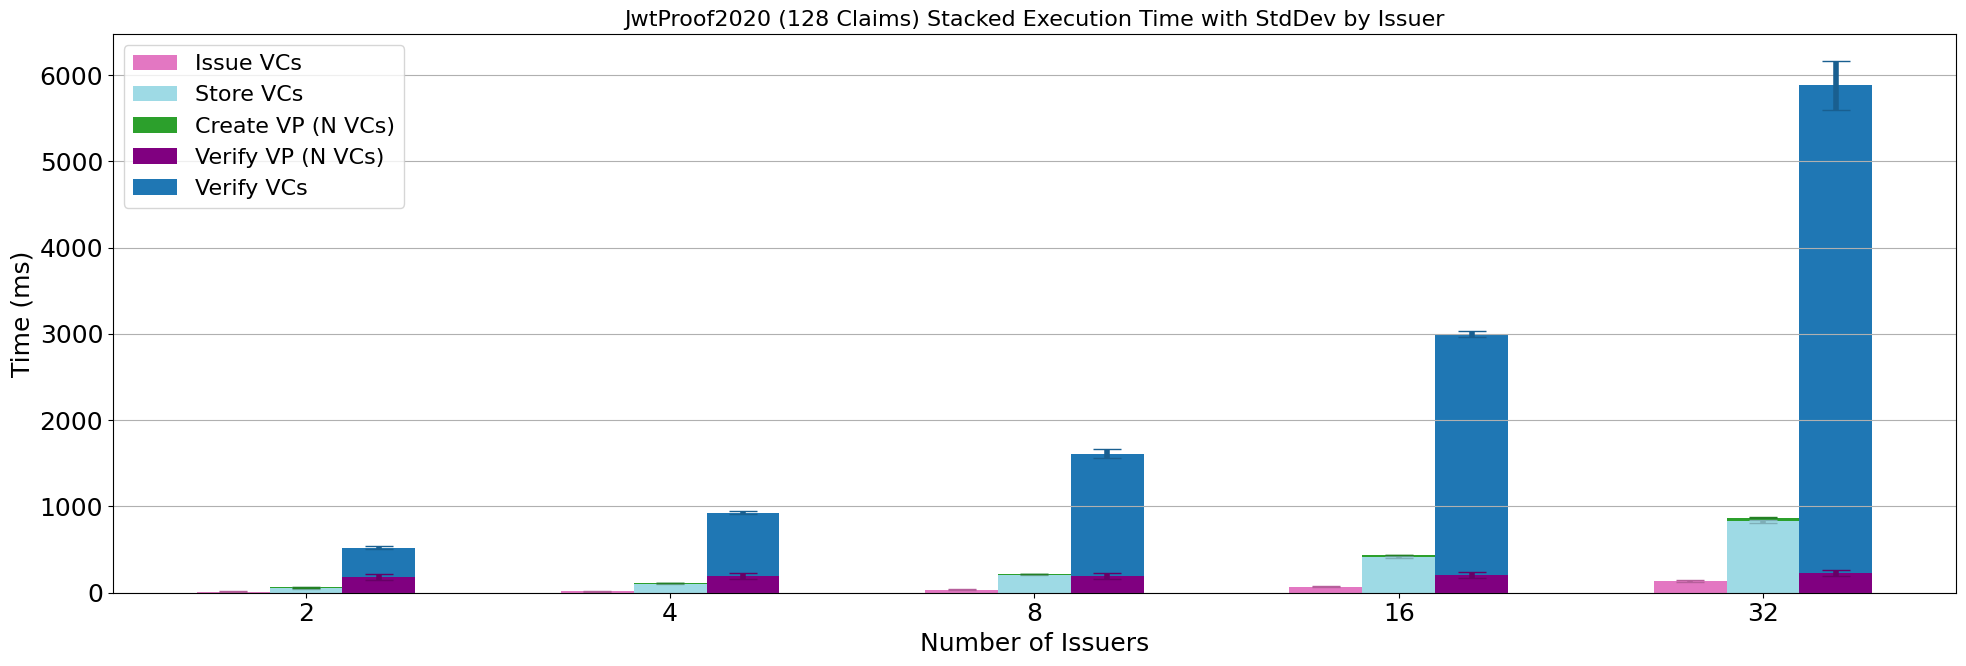

In [ ]:
# --- Process and Plot JwtProof2020 Data (df_jwt_128) ---

df_jwt_128["OperationGroup"] = df_jwt_128["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df_jwt_128 = df_jwt_128.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df_jwt_128 = df_jwt_128.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

grouped_steps_jwt = {
    "Issuing": [step for step in common_group1_steps if step in avg_df_jwt_128.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df_jwt_128.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df_jwt_128.columns]
}

# Plot
x_jwt = np.arange(len(avg_df_jwt_128.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_jwt.items()):
    bottom = np.zeros(len(avg_df_jwt_128))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df_jwt_128.columns:
            values = avg_df_jwt_128[step].values
            errors = std_df_jwt_128[step].values
            bars = ax.bar(x_jwt + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_jwt + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_jwt)
ax.set_xticklabels(avg_df_jwt_128.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("JwtProof2020 (128 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

### EIP712 (128 Claims) Plot

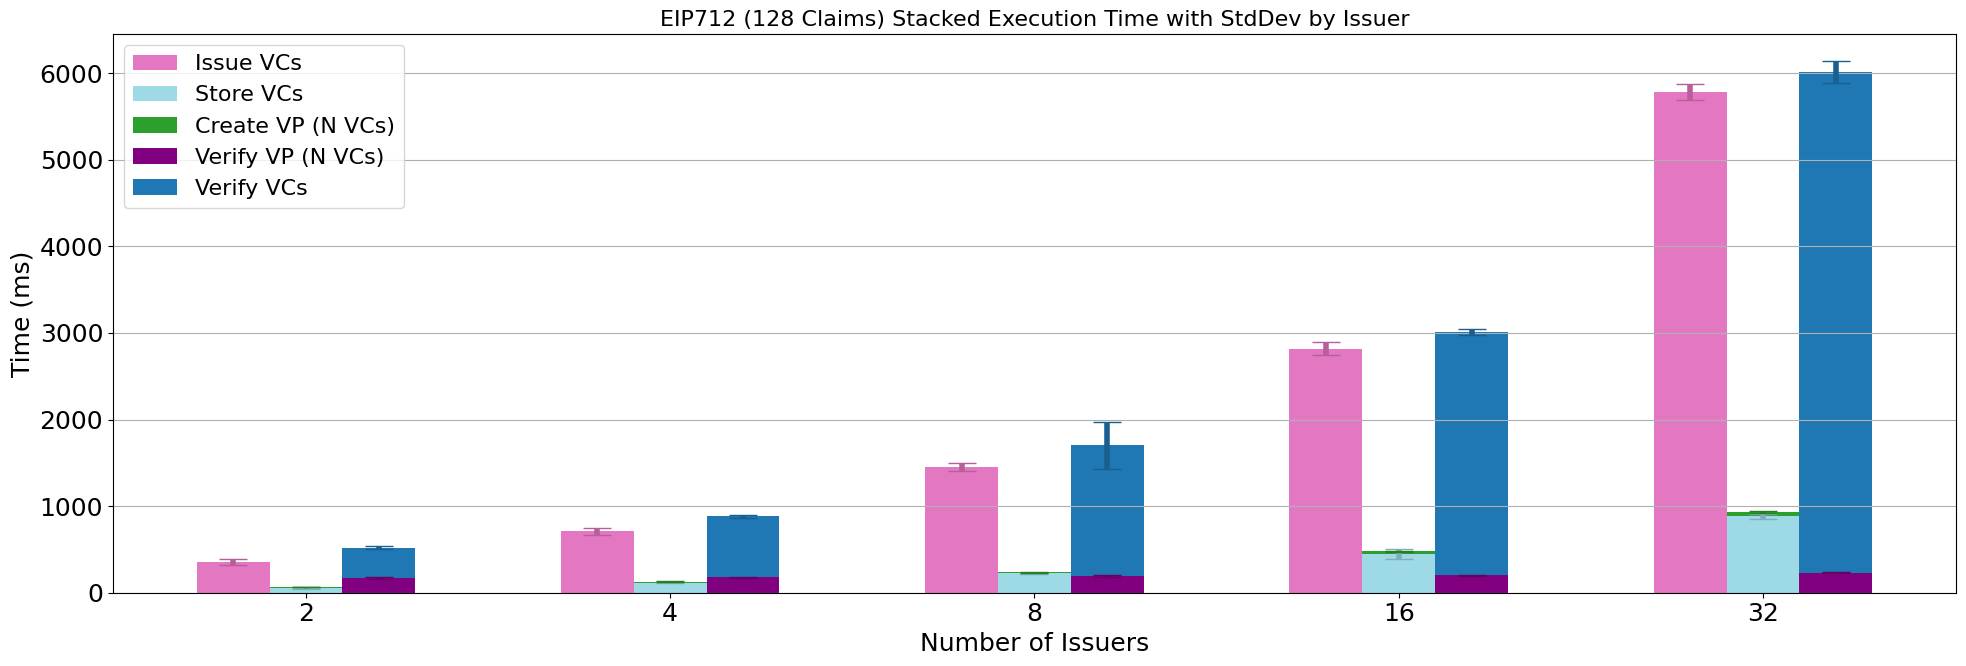

In [ ]:
# --- Process and Plot EIP712 Data (df_eip_128) ---

df_eip_128["OperationGroup"] = df_eip_128["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df_eip_128 = df_eip_128.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df_eip_128 = df_eip_128.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

grouped_steps_eip = {
    "Issuing": [step for step in common_group1_steps if step in avg_df_eip_128.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df_eip_128.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df_eip_128.columns]
}

# Plot
x_eip = np.arange(len(avg_df_eip_128.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_eip.items()):
    bottom = np.zeros(len(avg_df_eip_128))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df_eip_128.columns:
            values = avg_df_eip_128[step].values
            errors = std_df_eip_128[step].values
            bars = ax.bar(x_eip + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_eip + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_eip)
ax.set_xticklabels(avg_df_eip_128.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("EIP712 (128 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()

### MultiSignature (128 Claims) Plot

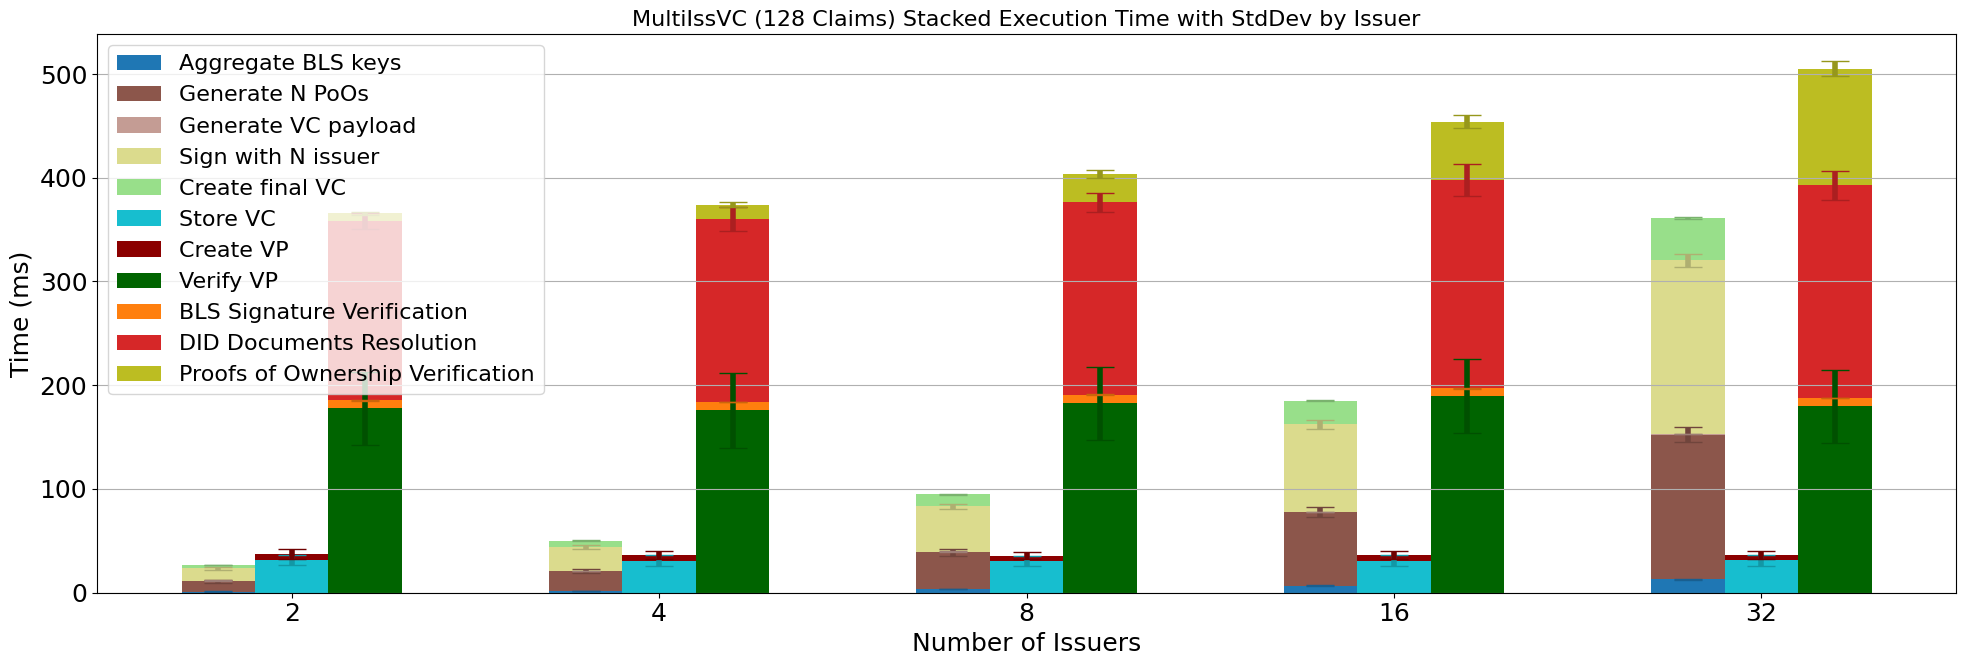

In [ ]:
# --- Process and Plot MultiSignature Data (df_multi_128) ---

# Fix typos
df_multi_128["StepName"] = df_multi_128["StepName"].replace({
    "DID DocumentS Resolution": "DID Documents Resolution"
})

# Classify steps
df_multi_128["OperationGroup"] = df_multi_128["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df_multi_128 = df_multi_128.pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc='mean').fillna(0).sort_index()
std_df_multi_128 = df_multi_128.pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc='mean').fillna(0).sort_index()

# Grouped step dictionary
grouped_steps_multi = {
    "Issuing": [step for step in common_group1_steps if step in avg_df_multi_128.columns],
    "Store & Present": [step for step in common_group2_steps if step in avg_df_multi_128.columns],
    "Verification": [step for step in common_group3_steps if step in avg_df_multi_128.columns]
}

# Plot
x_multi = np.arange(len(avg_df_multi_128.index))
bar_width = 0.2
fig, ax = plt.subplots(figsize=(20, 7))

for i, (group_label, steps) in enumerate(grouped_steps_multi.items()):
    bottom = np.zeros(len(avg_df_multi_128))
    offset = (i - 1) * bar_width
    for step in steps:
        if step in avg_df_multi_128.columns:
            values = avg_df_multi_128[step].values
            errors = std_df_multi_128[step].values
            bars = ax.bar(x_multi + offset, values, bottom=bottom, width=bar_width, label=step, color=common_step_colors.get(step, 'gray'))
            for xi, val, err, b in zip(x_multi + offset, bottom, errors, bars):
                ax.errorbar(
                    xi,
                    val + b.get_height(),
                    yerr=err,
                    ecolor=darken(common_step_colors.get(step, 'gray'), 0.8),
                    capsize=10,
                    fmt='none',
                    elinewidth=4
                )
            bottom += values

ax.set_xticks(x_multi)
ax.set_xticklabels(avg_df_multi_128.index.astype(str))
ax.set_xlabel("Number of Issuers")
ax.set_ylabel("Time (ms)")
ax.set_title("MultiIssVC (128 Claims) Stacked Execution Time with StdDev by Issuer")
ax.legend(loc='upper left')
ax.grid(axis='y')

plt.tight_layout()
plt.show()